In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
data_df = pd.read_excel('Energy Consumption.xlsx')
columns_name = ['Energy Consumption']
Data = pd.DataFrame(data_df, columns=columns_name)

In [ ]:
data_df

,Time,Energy Consumption
0,1972-04-01,139.546
1,1972-05-01,137.102
2,1972-06-01,131.366
3,1972-07-01,131.361
4,1972-08-01,140.293
...,...,...
595,2021-11-01,349.697
596,2021-12-01,306.670
597,2022-01-01,301.509
598,2022-02-01,337.633


<ipython-input-4-f64dc57344c0>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_df.index = pd.date_range(start='1972-04-01', periods=len(data_df), freq='M')


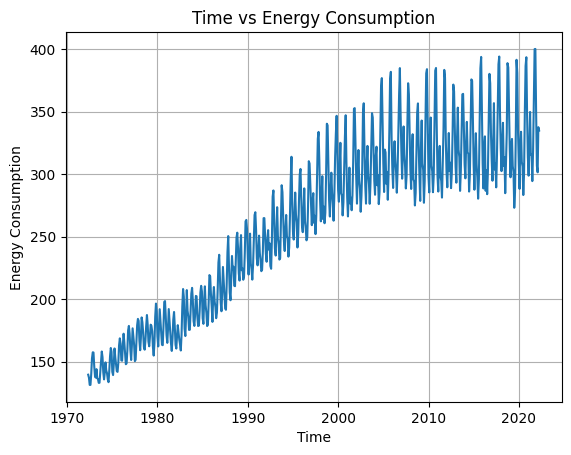

In [ ]:
data_df.index = pd.date_range(start='1972-04-01', periods=len(data_df), freq='M')
# Assuming 'Time' is the index of your DataFrame
plt.plot(data_df.index, data_df['Energy Consumption'])
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.title('Time vs Energy Consumption')
plt.grid(True)
plt.show()

In [ ]:
Data.describe()

,Energy Consumption
count,600.000000
mean,259.902547
std,68.908855
min,131.361000
25%,194.183000
50%,276.306000
75%,310.407000
max,400.275000


In [ ]:
def check_stationarity(data):

    # Perform Augmented Dickey-Fuller test
    result = adfuller(data)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")

    if result[1] > 0.05:
      print("Data is not stationary. Differencing is needed.")
      data_diff = Data['Energy Consumption'].diff().dropna()
    else:
      print("Data is stationary.")
      data_diff = Data['Energy Consumption']
# Check stationarity and trends
check_stationarity(Data)

ADF Statistic: -1.932675445114891
p-value: 0.31684907262282125
Data is not stationary. Differencing is needed.


In [ ]:
# Apply logarithmic transformation
log_transformed_data = np.log1p(Data['Energy Consumption'])

# Check stationarity for the log-transformed data
check_stationarity(log_transformed_data)

ADF Statistic: -2.8814920756945743
p-value: 0.04754293623948599
Data is stationary.


In [ ]:
import itertools
from statsmodels.tsa.arima.model import ARIMA

# Define the range of p, d, q values
p_values = [13, 25]
d_values = [0, 1]
q_values = [12, 24]

# Create a list of all possible combinations of p, d, q
param_combinations = list(itertools.product(p_values, d_values, q_values))

best_model = None
best_mse = float('inf')  # Initialize with a large value

# Loop through all combinations
for params in param_combinations:
    p, d, q = params

    # Fit the ARIMA model
    model_ARIMA = ARIMA(Data['Energy Consumption'], order=(p, d, q))
    model_ARIMA_fit = model_ARIMA.fit()

    # Make predictions
    predictions = model_ARIMA_fit.predict(start=1, end=len(Data['Energy Consumption']))

    # Evaluate the model using Mean Squared Error (MSE)
    mse = mean_squared_error(Data['Energy Consumption'], predictions)

    # Update the best model if the current one is better
    if mse < best_mse:
        best_mse = mse
        best_model = model_ARIMA_fit
        best_params = params

# Print the best model and its parameters
print("Best Model Parameters (p, d, q):", best_params)
print("Best Model MSE:", best_mse)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels

Best Model Parameters (p, d, q): (13, 0, 12)
Best Model MSE: 377.8772291330798


In [ ]:
# Determine the percentage of data to be used for training
train_percentage = 0.8

# Split the time series into training and validation sets
train_size = int(len(Data['Energy Consumption']) * train_percentage)
train_data = Data['Energy Consumption'][:train_size]
val_data = Data['Energy Consumption'][train_size:]

In [ ]:
# Define the ARIMA order
p = 13
d = 0
q = 12

# Fit ARIMA model on training data

model_ARIMA = ARIMA(train_data, order=(p, d, q))
model_ARIMA_fit = model_ARIMA.fit()

# Predictions for training data
predictions_train = model_ARIMA_fit.predict(start=1, end=len(train_data))

# Predictions for entire data
predictions_entire = model_ARIMA_fit.predict(start=1, end=len(Data['Energy Consumption']))

# Make predictions on validation data
predictions_val = model_ARIMA_fit.predict(start=len(train_data), end=len(Data['Energy Consumption'])-1, typ='levels')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
# Display the summary
print(model_ARIMA_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     Energy Consumption   No. Observations:                  480
Model:               ARIMA(13, 0, 12)   Log Likelihood               -1529.101
Date:                Mon, 13 Jan 2025   AIC                           3112.202
Time:                        05:05:37   BIC                           3224.894
Sample:                             0   HQIC                          3156.499
                                - 480                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        243.1124   1564.290      0.155      0.876   -2822.839    3309.064
ar.L1          0.5963      0.243      2.449      0.014       0.119       1.073
ar.L2          0.0099      0.024      0.404      0.6

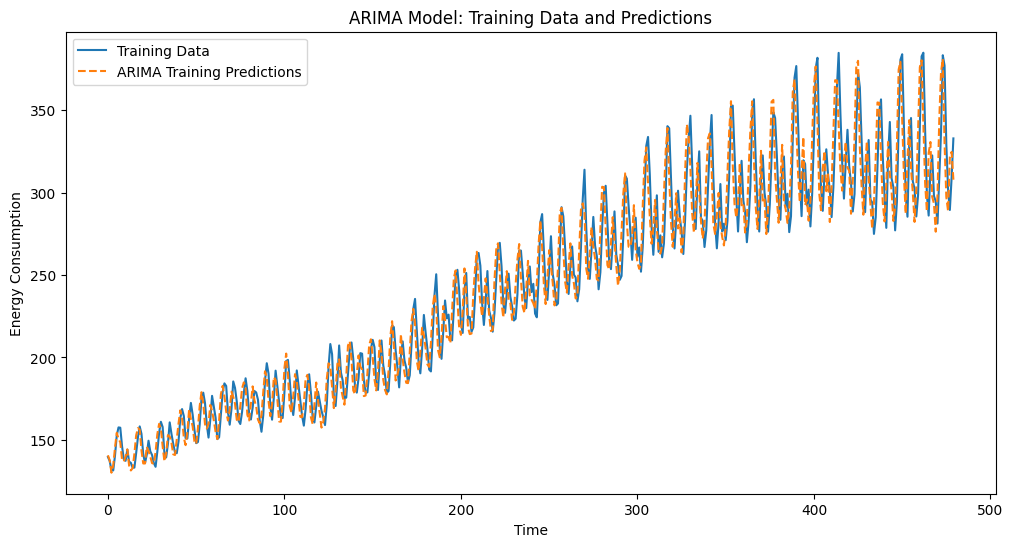

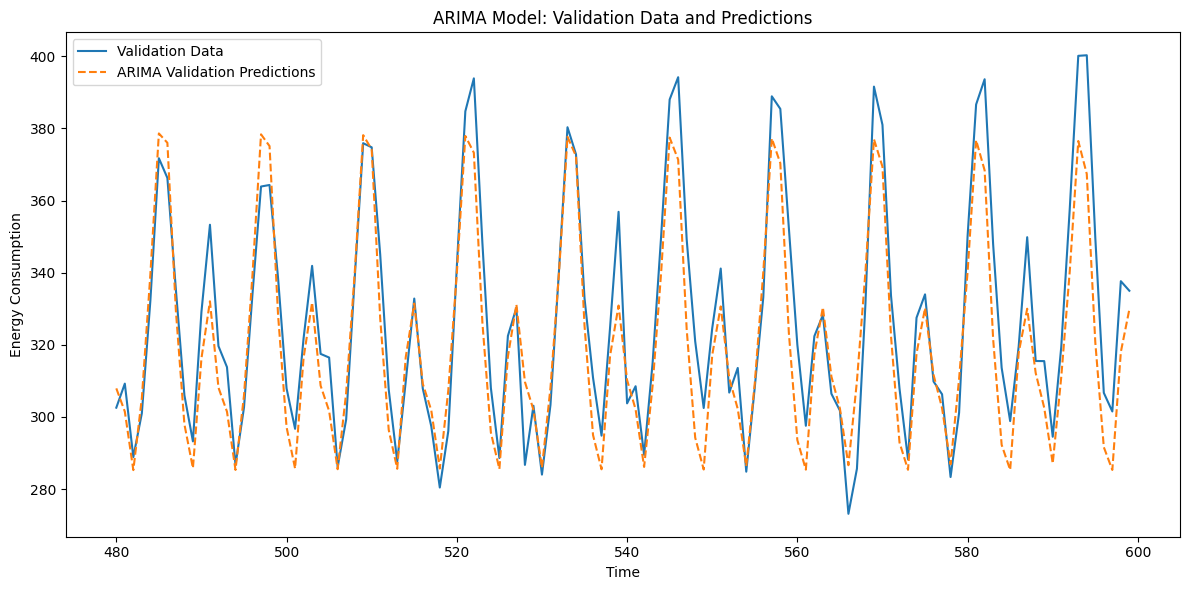

In [ ]:
# Plotting train data and train predictions
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(train_data.index, predictions_train, label='ARIMA Training Predictions', linestyle='--')
plt.title('ARIMA Model: Training Data and Predictions')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()

# Plotting test data and test predictions
plt.figure(figsize=(12, 6))
plt.plot(val_data.index, val_data, label='Validation Data')
plt.plot(val_data.index, predictions_val, label='ARIMA Validation Predictions', linestyle='--')
plt.title('ARIMA Model: Validation Data and Predictions')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Calculate R-squared for training data
r2_train = r2_score(train_data, predictions_train)
print(f"R-squared (Training): {r2_train}")

# Calculate R-squared for validation data
r2_val = r2_score(val_data, predictions_val)
print(f"R-squared (Validation): {r2_val}")

R-squared (Training): 0.9308684370578415
R-squared (Validation): 0.8384112152342237


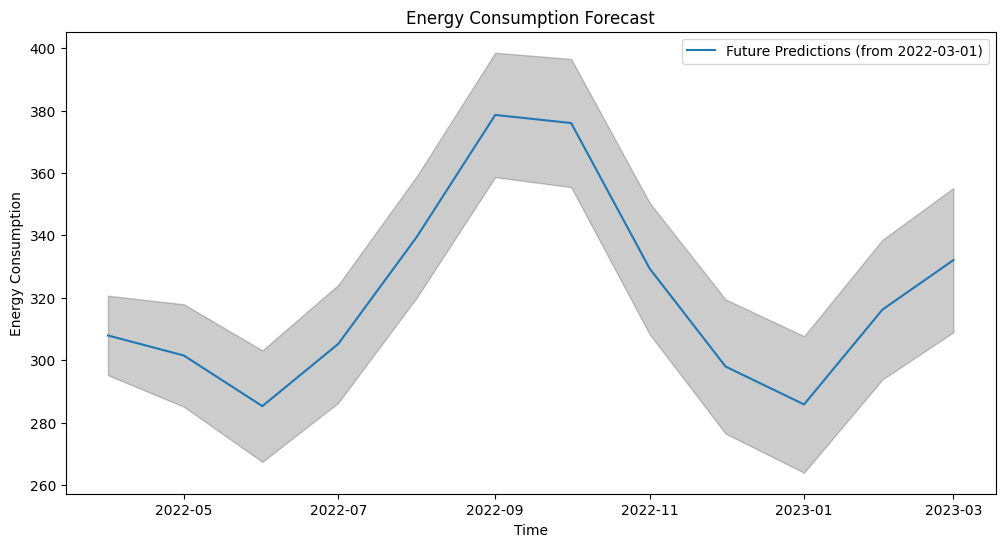

In [ ]:
# Forecasting for the next year
index_future_dates = pd.date_range(start='2022-04-01', periods=12, freq='MS')
pred_uc = model_ARIMA_fit.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
predictions_future = pred_uc.predicted_mean

# Create a DataFrame for the future predictions
future_predictions_df = pd.DataFrame({
    'Time': index_future_dates,
    'Predicted Energy Consumption': predictions_future
})

# Filter predictions from 2022-03-01 onwards
filtered_predictions_df = future_predictions_df[future_predictions_df['Time'] >= '2022-03-01']

# Reset index of pred_ci to match the future dates
pred_ci = pred_ci.reset_index(drop=True)  # Reset index
pred_ci.index = filtered_predictions_df['Time'] # set index to the future dates


# Plotting future predictions
plt.figure(figsize=(12, 6))
plt.plot(filtered_predictions_df['Time'], filtered_predictions_df['Predicted Energy Consumption'], label='Future Predictions (from 2022-03-01)')

# Use the reindexed pred_ci for fill_between
plt.fill_between(filtered_predictions_df['Time'], pred_ci['lower Energy Consumption'], pred_ci['upper Energy Consumption'], color='k', alpha=.2)


plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.title('Energy Consumption Forecast')
plt.legend()
plt.show()

# Save future predictions to a CSV file
future_predictions_df.to_csv('future_energy_predictions.csv', index=False)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
rmse = np.sqrt(mean_squared_error(Data['Energy Consumption'], predictions_entire))
mse = mean_squared_error(Data['Energy Consumption'], predictions_entire)
r2 = r2_score(Data['Energy Consumption'], predictions_entire)
print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"R-squared: {r2}")

RMSE: 21.124030457752617
MSE: 446.2246627800603
R-squared: 0.9058700291030639
